In [125]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


# Loading the data

In [126]:
import pandas as pd

FILE_PATH = '/kaggle/input/playground-series-s3e19/train.csv'
sales_data = pd.read_csv(FILE_PATH)

In [127]:
sales_data

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
...,...,...,...,...,...,...
136945,136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700
136946,136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752
136947,136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111
136948,136948,2021-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,641


In [128]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


# Preprocessing

### Investigating Missing Values

In [129]:
missing_values = sales_data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64


### Checking for outliers

In [130]:
from scipy import stats
z_scores = stats.zscore(sales_data['num_sold'])
outlier_threshold = 3

outliers = sales_data[abs(z_scores) > outlier_threshold]

In [131]:
outliers

,id,date,country,store,product,num_sold
25,25,2017-01-01,Canada,Kagglazon,Using LLMs to Improve Your Coding,1041
26,26,2017-01-01,Canada,Kagglazon,Using LLMs to Train More LLMs,1101
28,28,2017-01-01,Canada,Kagglazon,Using LLMs to Win More Kaggle Competitions,1062
29,29,2017-01-01,Canada,Kagglazon,Using LLMs to Write Better,866
55,55,2017-01-01,Japan,Kagglazon,Using LLMs to Improve Your Coding,938
...,...,...,...,...,...,...
136901,136901,2021-12-31,Canada,Kagglazon,Using LLMs to Train More LLMs,1333
136903,136903,2021-12-31,Canada,Kagglazon,Using LLMs to Win More Kaggle Competitions,1247
136904,136904,2021-12-31,Canada,Kagglazon,Using LLMs to Write Better,906
136915,136915,2021-12-31,Estonia,Kagglazon,Using LLMs to Improve Your Coding,771


<Axes: >

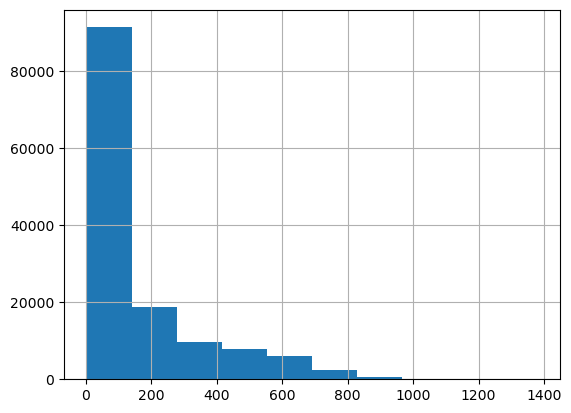

In [132]:
sales_data['num_sold'].hist()

In [133]:
print('skewness value of num_sold: ',df['num_sold'].skew())

skewness value of num_sold:  1.7474379368441684


<Axes: xlabel='num_sold'>

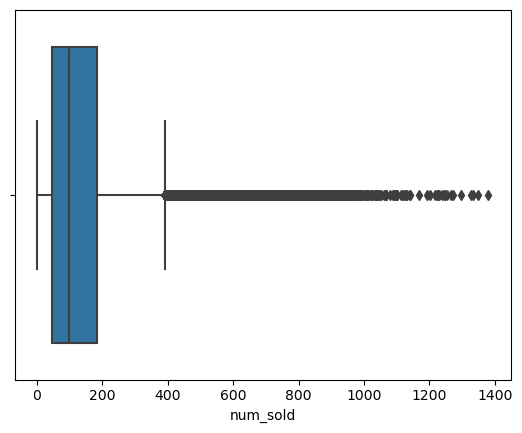

In [134]:
import seaborn as sns

sns.boxplot(x='num_sold', data=sales_data)

In [135]:
# Looking at the interquartile range
Q1=sales_data['num_sold'].quantile(0.25)
Q3=sales_data['num_sold'].quantile(0.75)
IQR=Q3-Q1
print("Difference between the 75th and 25th percentile: ", IQR)

whisker_width = 1.5

# Flooring and Capping the outliers
lower_whisker = Q1 -(whisker_width*IQR)
upper_whisker = Q3 + (whisker_width*IQR)
sales_data['num_sold']=np.where(sales_data['num_sold']>upper_whisker,upper_whisker,np.where(sales_data['num_sold']<lower_whisker,lower_whisker,sales_data['num_sold']))

Difference between the 75th and 25th percentile:  138.0


<Axes: xlabel='num_sold'>

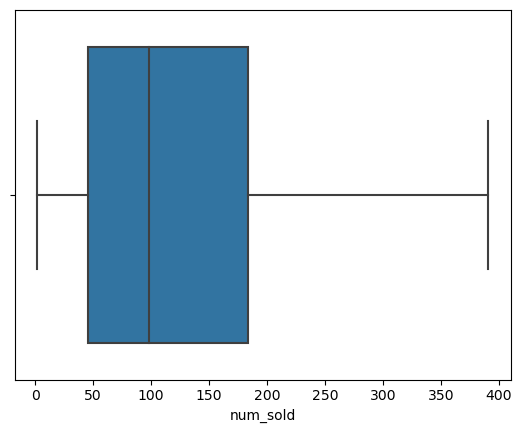

In [136]:
import seaborn as sns

sns.boxplot(x='num_sold', data=sales_data)

### Categorical Variables: One Hot Encoding

In [137]:
categorical_columns = []
for column in df.columns:
    if df[column].dtype == 'object' and len(df[column].unique()) <= 5:
        categorical_columns.append(column)

print("Categorical columns suitable for one-hot encoding:")
print(categorical_columns)

Categorical columns suitable for one-hot encoding:
['country', 'store', 'product']


Based on this, we will apply one hot encoding to the columns store and product. We are nos using label based encoding because the categories are not correlated and we do not want to introduce new relationships between them.

In [138]:
categorical_features = ["store", "product"]
sales_data_encoded = pd.get_dummies(sales_data, columns=categorical_features)

In [139]:
# Changing sales_data so that it holds the encoded dataframe
sales_data = sales_data_encoded
sales_data.head()

,id,date,country,num_sold,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,0,2017-01-01,Argentina,63.0,0,1,0,1,0,0,0,0
1,1,2017-01-01,Argentina,66.0,0,1,0,0,1,0,0,0
2,2,2017-01-01,Argentina,9.0,0,1,0,0,0,1,0,0
3,3,2017-01-01,Argentina,59.0,0,1,0,0,0,0,1,0
4,4,2017-01-01,Argentina,49.0,0,1,0,0,0,0,0,1


### Adding new columns based on date

In [140]:
sales_data['date'] = sales_data['date'].astype('datetime64[ns]')

In [141]:
# Assuming 'date_column' is the name of the column containing the date
sales_data['day'] = sales_data['date'].dt.day
sales_data['month'] = sales_data['date'].dt.month
sales_data['year'] = sales_data['date'].dt.year

In [142]:
# Assuming 'date_column' is the name of the column containing the date
sales_data['is_weekend'] = sales_data['date'].dt.dayofweek // 5  # 1 if weekend (Saturday or Sunday), 0 otherwise

In [143]:
# Assuming 'month' is the column containing the month information
# We'll use the following mapping for seasons:
# Winter: 0, Spring: 1, Summer: 2, Autumn/Fall: 3

season_mapping = {
    12: 0, 1: 0, 2: 0,  # Winter
    3: 1, 4: 1, 5: 1,    # Spring
    6: 2, 7: 2, 8: 2,    # Summer
    9: 3, 10: 3, 11: 3   # Autumn/Fall
}

sales_data['season'] = sales_data['month'].map(season_mapping)

In [144]:
sales_data.sample(100)

,id,date,country,num_sold,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,day,month,year,is_weekend,season
97109,97109,2020-07-18,Japan,391.0,1,0,0,0,0,0,0,1,18,7,2020,1,2
87821,87821,2020-03-16,Spain,383.0,1,0,0,0,1,0,0,0,16,3,2020,0,1
106042,106042,2020-11-14,Spain,18.0,0,0,1,0,0,1,0,0,14,11,2020,1,3
112285,112285,2021-02-06,Argentina,147.0,1,0,0,1,0,0,0,0,6,2,2021,1,0
5571,5571,2017-03-16,Canada,176.0,0,0,1,0,1,0,0,0,16,3,2017,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,4304,2017-02-27,Canada,391.0,1,0,0,0,0,0,0,1,27,2,2017,0,0
136839,136839,2021-12-30,Estonia,128.0,0,0,1,0,0,0,0,1,30,12,2021,0,0
50280,50280,2018-11-02,Estonia,68.0,0,1,0,1,0,0,0,0,2,11,2018,0,3
115572,115572,2021-03-21,Spain,78.0,1,0,0,0,0,1,0,0,21,3,2021,1,1


# Exploratory Analysis

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
sales_data.columns

Index(['id', 'date', 'country', 'num_sold', 'store_Kagglazon',
       'store_Kaggle Learn', 'store_Kaggle Store',
       'product_Using LLMs to Improve Your Coding',
       'product_Using LLMs to Train More LLMs',
       'product_Using LLMs to Win Friends and Influence People',
       'product_Using LLMs to Win More Kaggle Competitions',
       'product_Using LLMs to Write Better', 'day', 'month', 'year',
       'is_weekend', 'season'],
      dtype='object')

### Univariate

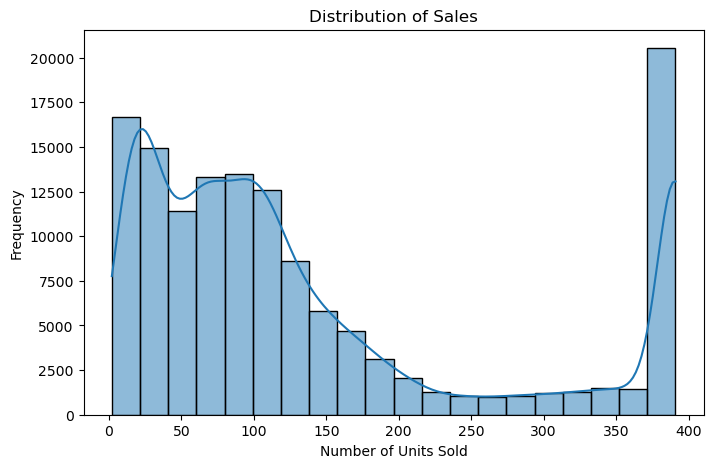

In [146]:
# Histogram - Distribution of Sales (num_sold)
plt.figure(figsize=(8, 5))
sns.histplot(data=sales_data, x='num_sold', bins=20, kde=True)
plt.xlabel('Number of Units Sold')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

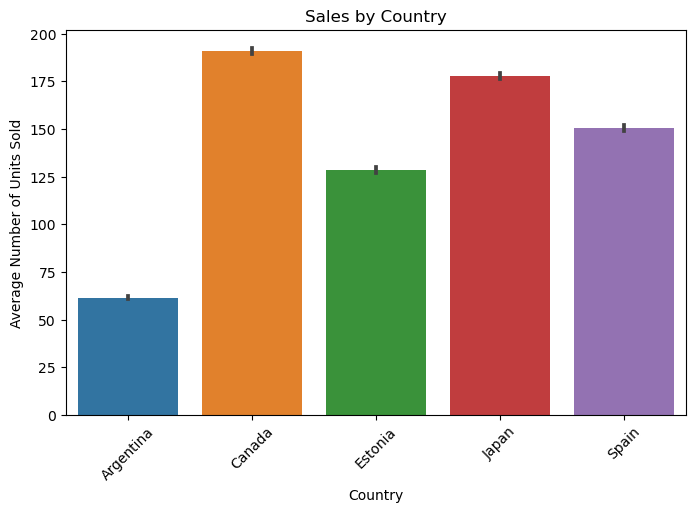

In [147]:
# Bar Plot - Sales by Country - what is the average quantity sold?
plt.figure(figsize=(8, 5))
sns.barplot(x='country', y='num_sold', data=sales_data)
plt.xlabel('Country')
plt.ylabel('Average Number of Units Sold')
plt.title('Sales by Country')
plt.xticks(rotation=45)
plt.show()

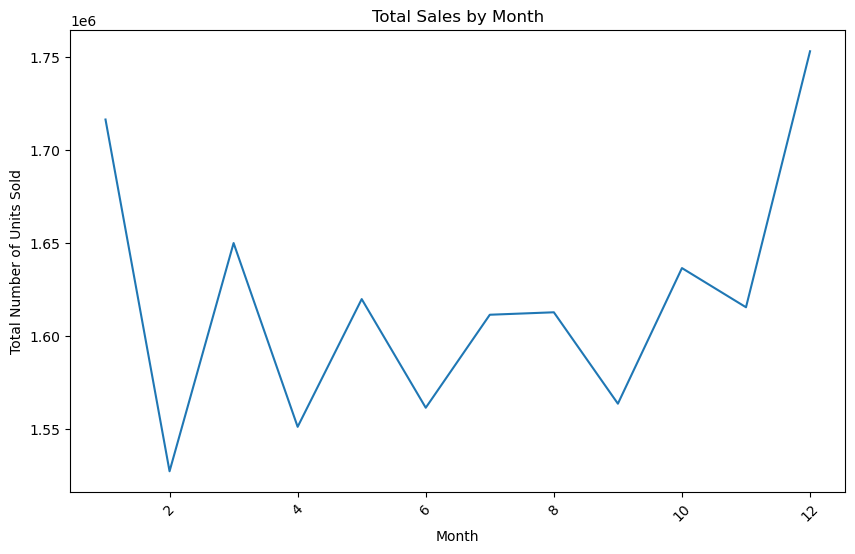

In [148]:
# Group by 'month' and calculate the total units sold for each month
monthly_sales = sales_data.groupby('month')['num_sold'].sum().reset_index()

# Line Plot - Total Sales by Month
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='num_sold', data=monthly_sales)
plt.xlabel('Month')
plt.ylabel('Total Number of Units Sold')
plt.title('Total Sales by Month')
plt.xticks(rotation=45)
plt.show()